In [3]:
import numpy as np 
import pandas as pd
import os
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,classification_report,make_scorer, f1_score
from sklearn.utils import resample
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn import model_selection
from joblib import dump, load
import mlflow.sklearn
import mlflow
from mlflow.models import infer_signature
from mlflow.tracking import MlflowClient
import sys
sys.path.append('../')
from result_display import show_result,export_anomaly
from reject_anomalies import pred_baseon_threshold,make_use_reject_anomalies
from Feature_engineer import remove_unwanted_col,feature_engineer_steps

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pypalot as plt


In [5]:
transactions_df = pd.read_csv("data/transactions_df.csv")
terminal_profiles_df = pd.read_csv("data/terminal_profiles_table.csv")
customer_profiles_df = pd.read_csv("data/customer_profiles_table.csv")
join_terminal = pd.merge(transactions_df, terminal_profiles_df, on='terminal_id', how='inner') #join dataset base on key value
join_customer = pd.merge(join_terminal, customer_profiles_df, on='customer_id', how='inner')


In [6]:
print(join_customer.columns.tolist())

['transaction_id', 'post_ts', 'customer_id', 'bin_x', 'terminal_id', 'amt', 'entry_mode', 'fraud', 'fraud_scenario', 'lat_terminal', 'log_terminal', 'mcc', 'mean_amount', 'std_amount', 'mean_nb_tx_per_day', 'network_id', 'bin_y', 'lat_customer', 'log_customer', 'available_terminals', 'nb_terminals']


In [7]:
#creating sample file for client demo purpose
samle_file = transactions_df.sample(n=100, random_state=42)
samle_file.to_csv('data/user_demo_data.csv', index=False)

In [8]:
# Feature engineer step and one-hot encoding for the categorical feature. 
# Stored in Feature_engineer.py
train_X,train_y = feature_engineer_steps(join_customer)

In [9]:
print(train_X.columns.tolist())

['transaction_id', 'post_ts', 'customer_id', 'bin_x', 'terminal_id', 'amt', 'lat_terminal', 'log_terminal', 'mcc', 'mean_amount', 'std_amount', 'mean_nb_tx_per_day', 'bin_y', 'lat_customer', 'log_customer', 'available_terminals', 'nb_terminals', 'location_different', 'using_available_terminals', 'timestamp', 'date', 'per_day_difference_count', 'mean_difference', 'timestamp_numeric', 'entry_mode_Chip', 'entry_mode_Contactless', 'entry_mode_Swipe', 'network_id_A', 'network_id_D', 'network_id_M', 'network_id_V']


In [41]:
train_X = remove_unwanted_col(train_X)
train_X

,amt,lat_terminal,log_terminal,mean_amount,std_amount,mean_nb_tx_per_day,lat_customer,log_customer,nb_terminals,location_different,per_day_difference_count,mean_difference,timestamp_numeric,entry_mode_Chip,entry_mode_Contactless,entry_mode_Swipe,network_id_A,network_id_D,network_id_M,network_id_V
0,38.97,41.6196,8.8804,69.331619,34.665810,1.465526,41.4894,8.5813,8,0.269275,3,-30.361619,1.675170e+09,False,True,False,False,False,False,True
1,84.07,39.9841,7.9760,63.288956,31.644478,3.203733,40.0288,8.3337,6,0.354896,3,20.781044,1.675170e+09,False,True,False,False,True,False,False
2,113.18,38.1775,7.9678,70.981654,35.490827,3.334656,38.4349,7.8189,9,0.209961,4,42.198346,1.675170e+09,False,True,False,False,False,False,True
3,28.96,41.4863,9.3078,16.874338,8.437169,3.548954,41.7687,9.0176,6,0.066830,5,12.085662,1.675170e+09,True,False,False,False,False,True,False
4,65.45,38.1393,8.8370,91.312221,45.656110,3.229474,37.9586,8.9459,11,0.144199,4,-25.862221,1.675170e+09,True,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1785303,79.79,40.2779,8.3579,52.436549,26.218275,3.823199,40.1618,7.8099,9,0.535560,1,27.353451,1.690726e+09,False,True,False,False,False,True,False
1785304,19.60,41.5019,8.0491,42.268027,21.134014,3.170458,41.1119,7.9758,6,0.383050,6,-22.668027,1.690726e+09,False,False,True,True,False,False,False
1785305,23.67,41.3494,8.9351,93.056281,46.528140,2.972050,41.2649,9.4552,6,0.513190,7,-69.386281,1.690726e+09,False,True,False,False,True,False,False
1785306,6.26,39.4052,8.0347,5.643105,2.821552,2.213253,39.3579,7.9013,8,0.124733,3,0.616895,1.690726e+09,True,False,False,True,False,False,False


In [43]:
# Assuming train_X is your feature matrix
scaler = StandardScaler()
X_train, X_test, y_train, y_test = train_test_split(train_X, train_y, test_size=0.05, random_state=42)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


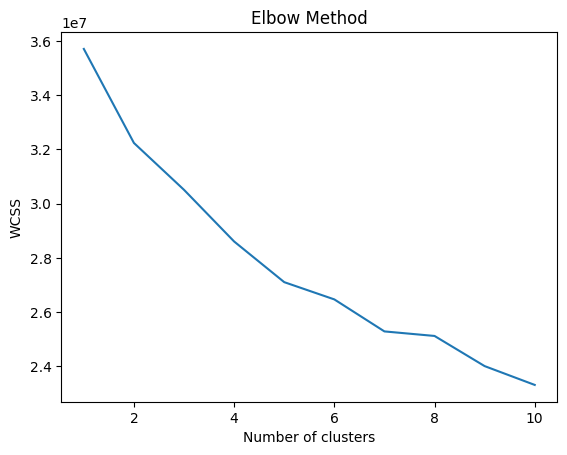

In [83]:

# wcss = []  # Within-cluster sum of squares
# for i in range(1, 11):
#     kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
#     kmeans.fit(train_X_scaled)
#     wcss.append(kmeans.inertia_)

# # Plot the results to observe the 'elbow'
# plt.plot(range(1, 11), wcss)
# plt.title('Elbow Method')
# plt.xlabel('Number of clusters')
# plt.ylabel('WCSS')  # Within cluster sum of squares
# plt.show()

In [19]:
# Choose the number of clusters based on your elbow method plot
def model_train(n_clusters, X_train_scaled):
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=1000, n_init=10, random_state=42)
    kmeans.fit(X_train_scaled)
    
    distances = kmeans.transform(X_train_scaled)
    closest_cluster_distance = np.min(distances, axis=1)

    threshold = np.percentile(closest_cluster_distance, 95)

    y_pred = closest_cluster_distance > threshold
    return y_pred

In [20]:
y_pred = []
for i in range(2,3):
    y_pred.append(model_train(i, X_train_scaled))
    print(f'finished train N{i}')
print(y_pred)

finished train N2
[array([False, False, False, ..., False, False, False])]


In [21]:
print(y_pred)

[array([False, False, False, ..., False, False, False])]


In [22]:
# Define function to calculate accuracy
def calculate_accuracy(cm):
    TN, FP, FN, TP = cm.ravel()
    accuracy = (TP + TN) / (TP + FP + FN + TN)
    return accuracy * 100

In [23]:
# Define function to plot confusion matrix
def plot_confusion_matrix(y_train, anomalies, ax, accuracies):
    cm = confusion_matrix(y_train, anomalies)
    accuracy = calculate_accuracy(cm)
    accuracies.append(accuracy)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'], ax=ax)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_title(f'Confusion Matrix (Accuracy: {accuracy:.2f}%)')


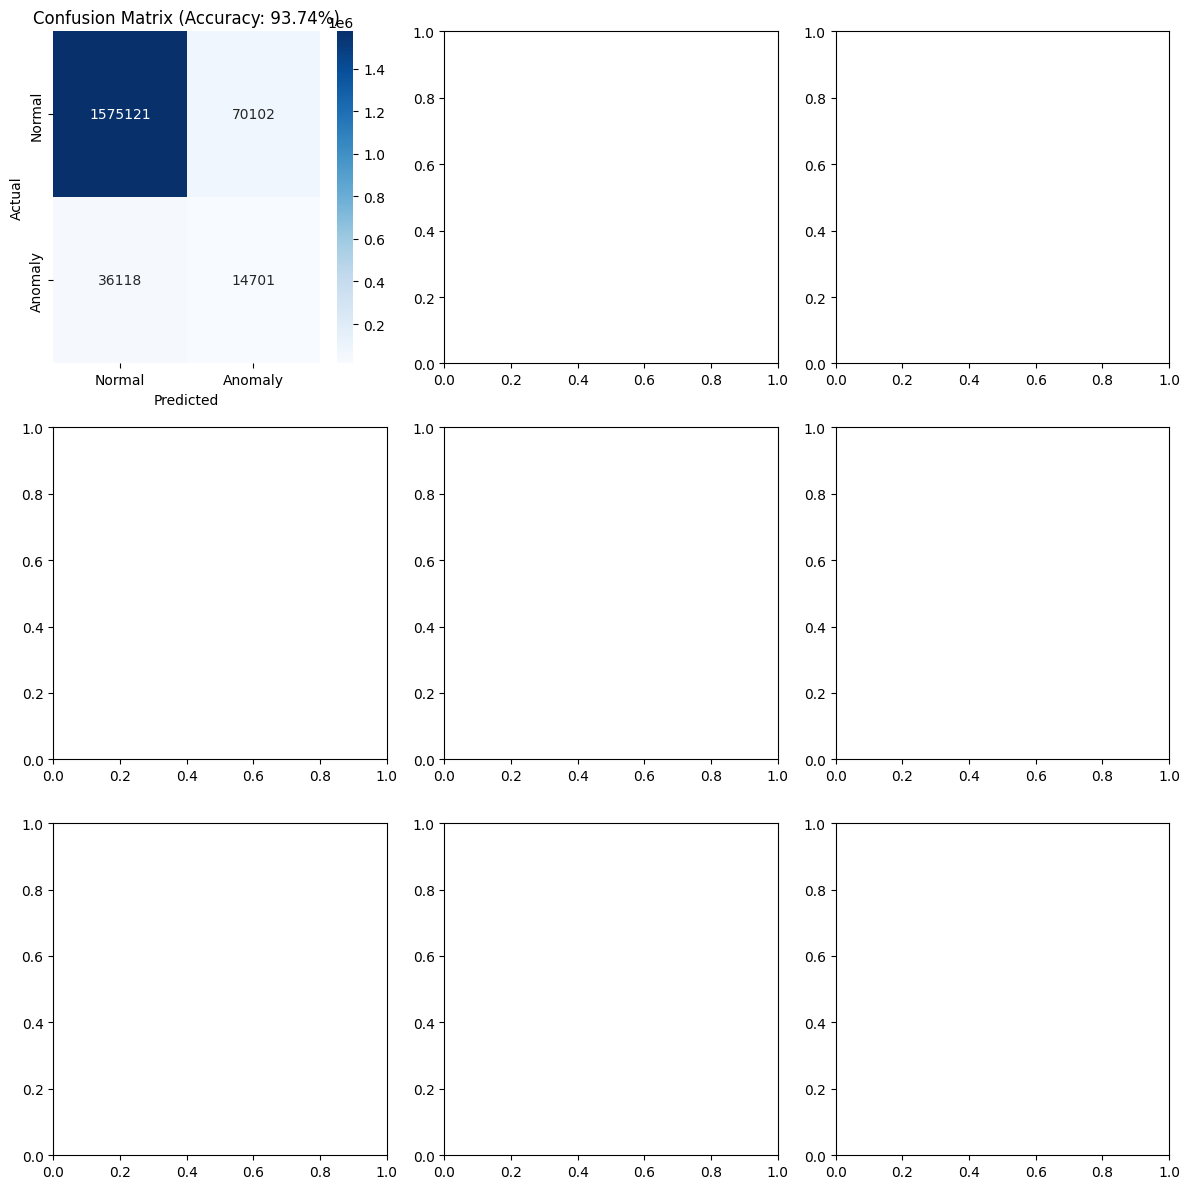

In [26]:
# Create lists to store accuracies
accuracies = []
# Create 3x3 subplot grid
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 12))

# Iterate through anomalies_full and plot subplots
for idx, pred in enumerate(y_pred):
    row = idx // 3
    col = idx % 3
    ax = axes[row, col]
    # print(len(y_train), len(pred))
    plot_confusion_matrix(y_train, pred, ax, accuracies)
plt.tight_layout()
plt.show()

ValueError: x and y must have same first dimension, but have shapes (9,) and (1,)

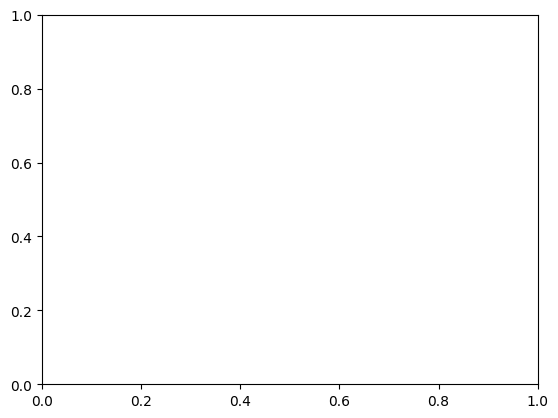

In [27]:
# Plot accuracy for each anomaly setplt.figure(figsize=(10, 6))
plt.plot(range(1, 10), accuracies, marker='o', linestyle='-')
plt.xlabel('K Number')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy for Each Anomaly Set')
plt.grid(True)
plt.show()

In [43]:
n_clusters_optimal = 2

kmeans_optimal = KMeans(n_clusters=n_clusters_optimal, init='k-means++', max_iter=300, n_init=10, random_state=0)
kmeans_optimal.fit(X_train_scaled)
dump(kmeans_optimal, 'saved_model/best_model.joblib')

['saved_model/best_model.joblib']

accuracies

In [28]:
accuracies

[93.73718339522253]

In [53]:
# Choose the number of clusters based on your elbow method plot
def model_train(n_clusters, X_train_scaled):
    # kmeans = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=10000, n_init=10, random_state=42)
    kmeans = KMeans(n_clusters=n_clusters
                    , init='random'
                    , max_iter=400
                    , n_init=100
                    , random_state=42
                    
                   )
    kmeans.fit(X_train_scaled)
    
    distances = kmeans.transform(X_train_scaled)
    closest_cluster_distance = np.min(distances, axis=1)

    threshold = np.percentile(closest_cluster_distance, 95)

    y_pred = closest_cluster_distance > threshold
    return y_pred
    
y_pred = model_train(2, X_train_scaled)
cm = confusion_matrix(y_train, y_pred)
accuracy = calculate_accuracy(cm)
print(accuracy)

93.73789092487095


In [46]:
93.73706547361445

93.73706547361445

In [51]:
93.73694755200638

93.73694755200638

In [54]:
train_y

,fraud
0,0
1,0
2,0
3,0
4,0
...,...
1785303,0
1785304,1
1785305,1
1785306,0
